# Lecture 9 – Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 779.8 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/9.8 MB 773.4 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/9.8 MB 773.4 kB/s eta 0:00:12
   ----- ---------------------------------- 1.3/9.8 MB 1.0 MB/s eta 0:00:09
   ------- -------------------------------- 1.8/9.8 MB 1.2 MB/s eta 0:00:07
   ------- -------------------------------- 1.8/9.8 MB 1.2 MB/s eta 0:00:07
   -------- ------------------------------- 2.1/9.8 MB 1.1 MB/s eta 0:00:07
   ---------------- ----------------------- 3.9/9.8 MB 1.9 MB/s eta 0:00:04
   ------------------------ --------------- 6.0/9.8 MB 2.6 MB/s eta 0:00:02
   ----------------------------- -


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install cufflinks

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68561 sha256=c58ef90cc285be7113eddc70dfc4f17fa33165f6e812660739f987aa75602766
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\13\bc\65\1ac45445dba1052b5e837dc49f5282c8cb2f934ae9e6f62f0e
Successfully built cufflinks

   -------------------- ------------------- 1/2 [cufflinks]
   -------------------- ------------------- 1/2 [cufflinks]
   -------------------- ------------------- 1/2 [cufflinks]
   ---------------------------------------- 2/2 [cufflinks]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import plotly.offline as py
import plotly.express as px

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=False)

In [7]:
# Wonhee's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Introduction

In this lecture we examine the process of Exploratory Data Analysis (EDA).  Often you will acquire or even be given a collection of data in order to conduct some analysis or answer some questions. The first step in using that data is to ensure that it is in the correct form (cleaned) and that you understand its properties and limitations (EDA).  Often as you explore data through EDA you will identify additional transformations that may be required before the data is ready for analysis.

In this notebook we obtain crime data from the city of Berkeley's public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data. 

# Getting the Data

To begin this analysis we want to get data about crimes in Berkeley.  Remarkably, the city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining the:

[Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5)

Fortunately, this data is also relatively well document with detailed descriptions of what it contains.  Here are summaries of the fields in the data:

### Calls Data
<img src="calls_desc.png" width=800px />





## Most data has bad documentation:

Unfortunately, data is seldom well documented and when it is you may not be able to trust the documentation. It is therefore critical that when we download the data we investigate the fields and verify that it reflects the assumptions made in the documentation.



## Load the Data

In [8]:
calls_file = "calls_for_service.csv"

# Exploring the data

Now that we have obtained the data we want to understand its:

* **Structure/Types** -- the "shape"/"type" of a data file
* **Granularity** -- how fine/coarse is each datum
* **Scope** -- how (in)complete is the data
* **Temporality** -- how is the data situated in time
* **Faithfulness** -- how well does the data capture "reality"



## Structure

Before we even begin to load the data it often helps to understand a little about the high-level structure:

1. How much data do I have?
1. How is it formatted?

### How big is the data?

I often like to start my analysis by getting a rough estimate of the size of the data.  This will help inform the tools I use and how I view the data.  If it is relatively small I might use a text editor or a spreadsheet to look at the data.  If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

However here we will use python tools to probe the file.

In [10]:
import os
print(calls_file, "is",  os.path.getsize(calls_file) / 1e6, "MB")

calls_for_service.csv is 0.941358 MB


All the files are relatively small and we could comfortable examine them in a text editors.  

In listing the files I noticed that the names suggest that they are all text file formats:
* **CSV**: Comma separated values is a very standard table format.

We will dive into the formats in a moment.  However because these are text data I might also want to investigate the number of lines which often correspond to records.

In [11]:
with open(calls_file, "r") as f:
    print(calls_file, "is", sum(1 for l in f), "lines.")

calls_for_service.csv is 15452 lines.



### What is the file format?  (Can we trust extensions?)

We already noticed that the file end in `csv` which suggests that these is comma separated file.  However, we can't always rely on the naming as this is only a convention.  For example, here we picked the name of the file when downloading based on some hints in the URL.



**Often files will have incorrect extensions or no extension at all.**

Let's assume that these are text files (and do not contain binary encoded data) so we can print a "few lines" to get a better understanding of the file.

In [12]:
print(calls_file, "======================")
with open(calls_file, "r") as f:
    for i in range(20):
        print(i, "\t", repr(f.readline()))

calls_for_service.csv ======================
0 	 'CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State\n'
1 	 '19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\n'
2 	 'Berkeley, CA",2950 DURANT ST,Berkeley,CA\n'
3 	 '19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\n'
4 	 'Berkeley, CA",300 CANYON RD,Berkeley,CA\n'
5 	 '19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\n'
6 	 'Berkeley, CA",4TH ST,Berkeley,CA\n'
7 	 '19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\n'
8 	 'Berkeley, CA",100 MENLO PL,Berkeley,CA\n'
9 	 '19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\n'
10 	 'Berkeley, CA",800 HILLCREST RD,Berkeley,CA\n'
11 	 '19092685,BURGLARY AUTO,12/

### What are some observations about `Calls` data?

1. It appears to be in comma separated value (CSV) format.
1. First line contains the column headings.
1. There are lots of **new-line** `\n` characters:
    * at the ends of lines (delimiting records?)
    * *within records* as part of addresses.
1. There are **"quoted"** strings in the `Block_Location` column:
```
"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)"
```
these are going to be difficult.  What are the implications on our earlier line count calculations?


## Loading the Data

We will now attempt to load the data into python.  We will be using the Pandas dataframe library for basic tabular data analysis.  Fortunately, the Pandas library has some relatively sophisticated functions for loading data. 


### Loading the Calls Data

Because the file appears to be a relatively well formatted CSV we will attempt to load it directly and allow the Pandas Library to deduce column headers.  (Always check that first row and column look correct after loading.)

In [13]:
calls = pd.read_csv(calls_file)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA


How many records did we get?

In [14]:
calls.shape[0]

5227

### Preliminary observations on the data?

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Appears to be some encoding of the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.


### Checking that the City and State fields are all Berkeley CA

We notice that there are city and state columns.  Since this is supposed to be data for the city of Berkeley these columns appear to be redundant.  Let's quickly compute the number of occurences of unique values for these two columns.

In [15]:
calls.groupby(["City", "State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
City,State,,,,,,,,,
Berkeley,CA,5227,5227,5227,5227,5227,5227,5227,5227,5190


### Decoding day of the week

According to the documentation `CVDOW=0` is Sunday, `CVDOW=1` is Monday, ...,  Therefore we can make a series to decode the day of the week for each record and join that series with the calls data.

In [16]:
dow = pd.Series(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], name="Day")
dow

0       Sunday
1       Monday
2      Tuesday
3    Wednesday
4     Thursday
5       Friday
6     Saturday
Name: Day, dtype: object

In [17]:
df_dow = pd.DataFrame(dow)

#### Notice that I am dropping the column if it already exists to
#### make it so I can run this cell more than once

In [22]:
calls = pd.merge(calls.drop(columns="Day", errors="ignore"), df_dow, left_on='CVDOW', right_index=True).sort_index()
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
5222,19092587,BURGLARY RESIDENTIAL,11/21/2019 12:00:00 AM,04:45,BURGLARY - RESIDENTIAL,4,06/25/2020 07:00:16 AM,"3100 ELLIS ST\nBerkeley, CA\n(37.852066, -122....",3100 ELLIS ST,Berkeley,CA,Thursday
5223,19043809,DISTURBANCE,08/08/2019 12:00:00 AM,23:50,DISORDERLY CONDUCT,4,06/25/2020 07:00:11 AM,"2500 DURANT AV\nBerkeley, CA\n(37.867852, -122...",2500 DURANT AV,Berkeley,CA,Thursday
5224,19092364,BURGLARY AUTO,10/26/2019 12:00:00 AM,16:50,BURGLARY - VEHICLE,6,06/25/2020 07:00:15 AM,"100 TAMALPAIS RD\nBerkeley, CA\n(37.885312, -1...",100 TAMALPAIS RD,Berkeley,CA,Saturday
5225,19040012,BURGLARY AUTO,07/22/2019 12:00:00 AM,19:30,BURGLARY - VEHICLE,1,06/25/2020 07:00:11 AM,"HEARST AV & 4TH ST\nBerkeley, CA\n(37.868878, ...",HEARST AV & 4TH ST,Berkeley,CA,Monday


### Cleaning Block Location

The block location contains the latitude/longitude coordinates and I might want to use these to analyze the location of each request.  Let's try to extract the GPS coordinates using regular expressions.


In [24]:
calls.loc[5226, 'Block_Location']

'2300 TELEGRAPH AV\nBerkeley, CA\n(37.868714, -122.259189)'

In [25]:
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t") 
    # Extract latitude and longitude using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*\.\d*)\)", expand=True)
)
calls_lat_lon.head(20)

<>:5: SyntaxWarning:

invalid escape sequence '\('

<>:5: SyntaxWarning:

invalid escape sequence '\('

C:\Users\user\AppData\Local\Temp\ipykernel_20704\1120582216.py:5: SyntaxWarning:

invalid escape sequence '\('



,Lat,Lon
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


Not all the records have a lat and lon.  What fraction do have coordinates?

In [26]:
(~calls_lat_lon.isnull()).mean()

Lat    0.963076
Lon    0.963076
dtype: float64

The following block of code joins the extracted Latitude and Longitude fields with the calls data.  Notice that we actually drop these fields before joining.  This is to enable repeated invocation of this cell even after the join has been completed. 

In [27]:
# Remove Lat and Lon if they already existed before (reproducible)
calls.drop(["Lat", "Lon"], axis=1, inplace=True, errors="ignore")
# Join in the the latitude and longitude data
calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday,NaN,NaN
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday,NaN,NaN


We can now look at a few of the records that were missing latitude and longitude entries:

In [28]:
calls[calls['Lat'].isnull()].head(10)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday,NaN,NaN
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday,NaN,NaN
5,19092685,BURGLARY AUTO,12/02/2019 12:00:00 AM,09:10,BURGLARY - VEHICLE,1,06/25/2020 07:00:17 AM,"MARINA BLVD\nBerkeley, CA",MARINA BLVD,Berkeley,CA,Monday,NaN,NaN
6,19043231,SEXUAL ASSAULT FEL.,08/04/2019 12:00:00 AM,00:00,SEX CRIME,0,06/25/2020 07:00:12 AM,"<UNKNOWN>\nBerkeley, CA",<UNKNOWN>,Berkeley,CA,Sunday,NaN,NaN
7,19092551,THEFT MISD. (UNDER $950),11/17/2019 12:00:00 AM,12:00,LARCENY,0,06/25/2020 07:00:16 AM,"ASHBY AVE\nBerkeley, CA",ASHBY AVE,Berkeley,CA,Sunday,NaN,NaN
8,19053206,THEFT FROM AUTO,09/15/2019 12:00:00 AM,21:00,LARCENY - FROM VEHICLE,0,06/25/2020 07:00:13 AM,"500 ETON CT\nBerkeley, CA",500 ETON CT,Berkeley,CA,Sunday,NaN,NaN
9,19056444,NARCOTICS,10/05/2019 12:00:00 AM,15:07,DRUG VIOLATION,6,06/25/2020 07:00:14 AM,"1605 62ND TER\nBerkeley, CA",1605 62ND TER,Berkeley,CA,Saturday,NaN,NaN


Are there any patterns to the missing data?

--- 

<br/><br/><br/>

# EDA 

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

In [29]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday,NaN,NaN
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday,NaN,NaN


---
<br/><br/><br/>

### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [34]:
print("There are", calls['CASENO'].unique().shape[0], "unique case numbers.")
print("There are", calls.shape[0], "calls in the table.")

There are 5227 unique case numbers.
There are 5227 calls in the table.


Are case numbers assigned consecutively.  

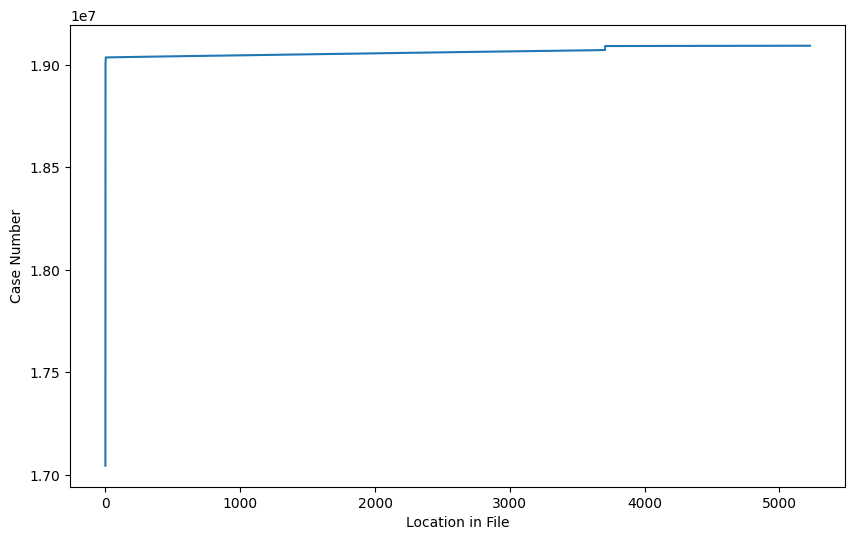

In [36]:
sorted_case_numbers = calls['CASENO'].sort_values().reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.plot(sorted_case_numbers.index, sorted_case_numbers.values)
plt.xlabel('Location in File')
plt.ylabel('Case Number')
plt.show()

I like to use interactive plotting tools so I can hover the mouse over the plot and read the values.  The cufflinks library adds plotly support to Pandas.  

### What might we be observing?

One possible explanation is that case numbers were assigned consecutively and then sampled uniformly at different rates for two different periods.  We will be able to understand this better by looking at the dates on the cases.

---
<br/><br/><br/>

## Examining the Date

Given the weird behavior with the case numbers let's dig into the date in which events were recorded.  Notice in this data we have several pieces of date/time information (this is not uncommon):
1. **`EVENTDT`**: This contains the date the event took place.  While it has time information the time appears to be `00:00:00`.  
1. **`EVENTTM`**: This contains the time at which the event took place.
1. **`InDbDate`**: This appears to be the date at which the data was entered in the database.  

In [37]:
calls.head(3)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN


When Pandas loads more complex fields like dates it will often load them as strings:

In [38]:
calls["EVENTDT"][0]

'10/22/2019 12:00:00 AM'

We will want to convert these to dates.  Pandas has a fairly sophisticated function `pd.to_datetime` which is capable of guessing reasonable conversions of dates to date objects. 

In [39]:
dates = pd.to_datetime(calls['EVENTDT'])
dates[0]

C:\Users\user\AppData\Local\Temp\ipykernel_20704\1442841332.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Timestamp('2019-10-22 00:00:00')

We can verify that the translations worked by looking at a few dates:

In [40]:
pd.DataFrame(dict(transformed=dates, original=calls["EVENTDT"])).head()

,transformed,original
0,2019-10-22,10/22/2019 12:00:00 AM
1,2019-07-21,07/21/2019 12:00:00 AM
2,2019-11-19,11/19/2019 12:00:00 AM
3,2019-09-10,09/10/2019 12:00:00 AM
4,2019-12-05,12/05/2019 12:00:00 AM


We can also extract the time field:

In [41]:
times = pd.to_datetime(calls["EVENTTM"]).dt.time
times.head()

C:\Users\user\AppData\Local\Temp\ipykernel_20704\3419886424.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



0    12:06:00
1    04:30:00
2    22:00:00
3    19:00:00
4    15:45:00
Name: EVENTTM, dtype: object

To combine the correct date and correct time field we use the built-in python datetime combine function.

In [42]:
from datetime import datetime
timestamps = pd.concat([dates, times], axis=1).apply(
    lambda r: datetime.combine(r["EVENTDT"], r["EVENTTM"]), axis=1
)
timestamps.head()

0   2019-10-22 12:06:00
1   2019-07-21 04:30:00
2   2019-11-19 22:00:00
3   2019-09-10 19:00:00
4   2019-12-05 15:45:00
dtype: datetime64[ns]

We now updated calls to contain this additional informations:

In [43]:
calls['timestamp'] = timestamps
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN,2019-10-22 12:06:00
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN,2019-07-21 04:30:00
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN,2019-11-19 22:00:00
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday,NaN,NaN,2019-09-10 19:00:00
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday,NaN,NaN,2019-12-05 15:45:00


In [30]:
df_interact(calls)

interactive(children=(IntSlider(value=0, description='row', max=5227, step=7), IntSlider(value=0, description=…

(5227 rows, 15 columns) total


### What time range does the data represent

In [44]:
calls['timestamp'].min()

Timestamp('2019-07-01 00:00:00')

In [45]:
calls['timestamp'].max()

Timestamp('2019-12-20 01:30:00')

---
<br/><br/><br/>


### Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [46]:
dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
calls.groupby('Day')['CASENO'].count()[dow]

Day
Sunday       660
Monday       788
Tuesday      730
Wednesday    751
Thursday     771
Friday       778
Saturday     749
Name: CASENO, dtype: int64

In [ ]:
dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
calls.groupby('Day')['CASENO'].count()[dow].iplot(kind='bar', yTitle="Count")

### How about temporal patterns within a day?

In [50]:
calls['hour_of_day'] = calls['timestamp'].dt.hour * 60 + calls['timestamp'].dt.minute / 60

In [58]:
py.iplot(ff.create_distplot([calls['hour_of_day']],group_labels=["Hour"],bin_size=1, show_rug=False))

### Observations?

In the above plot we see the standard pattern of limited activity early in the morning around here 6:00AM.

---
<br/><br/><br/>

### Examining the Event

We also have data about the different kinds of crimes being reported

In [51]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Lat,Lon,timestamp,hour_of_day
0,19059951,DISTURBANCE,10/22/2019 12:00:00 AM,12:06,DISORDERLY CONDUCT,2,06/25/2020 07:00:15 AM,"2950 DURANT ST\nBerkeley, CA",2950 DURANT ST,Berkeley,CA,Tuesday,NaN,NaN,2019-10-22 12:06:00,720.10
1,19039736,DISTURBANCE,07/21/2019 12:00:00 AM,04:30,DISORDERLY CONDUCT,0,06/25/2020 07:00:11 AM,"300 CANYON RD\nBerkeley, CA",300 CANYON RD,Berkeley,CA,Sunday,NaN,NaN,2019-07-21 04:30:00,240.50
2,19066056,BURGLARY AUTO,11/19/2019 12:00:00 AM,22:00,BURGLARY - VEHICLE,2,06/25/2020 07:00:16 AM,"4TH ST\nBerkeley, CA",4TH ST,Berkeley,CA,Tuesday,NaN,NaN,2019-11-19 22:00:00,1320.00
3,19051156,VEHICLE STOLEN,09/10/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,2,06/25/2020 07:00:13 AM,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA,Tuesday,NaN,NaN,2019-09-10 19:00:00,1140.00
4,19068960,BURGLARY AUTO,12/05/2019 12:00:00 AM,15:45,BURGLARY - VEHICLE,4,06/25/2020 07:00:17 AM,"800 HILLCREST RD\nBerkeley, CA",800 HILLCREST RD,Berkeley,CA,Thursday,NaN,NaN,2019-12-05 15:45:00,900.75


### The Offense Field

The Offense field appears to contain the specific crime being reported.  As nominal data we might want to see a summary constructed by computing counts of each offense type:

In [57]:
calls['OFFENSE'].value_counts().iplot(kind="bar")

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of bar.marker.line
        Received value: 'rgba(255, 153, 51, np.float64(1.0))'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color: see https://plotly.com/python/css-colors/ for a list
      - A number that will be interpreted as a color
        according to bar.marker.line.colorscale
      - A list or array of any of the above

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

---
<br/><br/><br/>

### CVLEGEND

The CVLEGEND field provides the broad category of crime and is a good mechanism to group potentially similar crimes. 

In [55]:
calls['CVLEGEND'].value_counts().iplot(kind="bar")

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of bar.marker.line
        Received value: 'rgba(255, 153, 51, np.float64(1.0))'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color: see https://plotly.com/python/css-colors/ for a list
      - A number that will be interpreted as a color
        according to bar.marker.line.colorscale
      - A list or array of any of the above

Notice that when we group by the crime time we see that **larceny** emerges as one of the top crimes.  Larceny is essentially stealing -- taking someone else stuff without force.